In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


(6000, 784) (1000, 784) (6000,) (1000, 10)
2.30253222428986  loss for each epoch
2.3025977169497156  loss for each epoch
2.302597662495523  loss for each epoch
2.302597608177879  loss for each epoch
2.3025975538690315  loss for each epoch
2.302597499568963  loss for each epoch
2.3025974452776734  loss for each epoch
2.302597390995159  loss for each epoch
2.3025973367214165  loss for each epoch
2.302597282456444  loss for each epoch
2.3025972282002383  loss for each epoch
2.3025971739527975  loss for each epoch
2.302597119714119  loss for each epoch
2.302597065484199  loss for each epoch
2.3025970112630367  loss for each epoch
2.3025969570506266  loss for each epoch
2.302596902846969  loss for each epoch
2.3025968486520605  loss for each epoch
2.302596794465897  loss for each epoch
2.302596740288477  loss for each epoch
2.3025966861197973  loss for each epoch
2.3025966319598563  loss for each epoch
2.3025965778086506  loss for each epoch
2.302596523666177  loss for each epoch
2.30259646

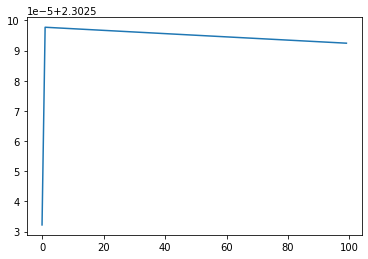

In [73]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve
import pandas as pd

class MyNeuralNetwork():
    """
    My implementation of a Neural Network Classifier.
    Source: https://towardsdatascience.com/implementing-different-activation-functions-and-weight-initialization-methods-using-python-c78643b9f20f
    """

    acti_fns = ['relu', 'sigmoid', 'linear', 'tanh', 'softmax']
    weight_inits = ['zero', 'random', 'normal']

    def __init__(self, n_layers, layer_sizes, activation, learning_rate, weight_init, batch_size, num_epochs):
        """
        Initializing a new MyNeuralNetwork object

        Parameters
        ----------
        n_layers : int value specifying the number of layers

        layer_sizes : integer array of size n_layers specifying the number of nodes in each layer

        activation : string specifying the activation function to be used
                     possible inputs: relu, sigmoid, linear, tanh

        learning_rate : float value specifying the learning rate to be used

        weight_init : string specifying the weight initialization function to be used
                      possible inputs: zero, random, normal

        batch_size : int value specifying the batch size to be used

        num_epochs : int value specifying the number of epochs to be used
        """

        if activation not in self.acti_fns:
            raise Exception('Incorrect Activation Function')

        if weight_init not in self.weight_inits:
            raise Exception('Incorrect Weight Initialization Function')

        self.n_layers = n_layers
        self.layer_sizes = layer_sizes
        self.activation = activation
        self.learning_rate = learning_rate
        self.weight_init = weight_init
        self.batch_size = batch_size
        self.num_epochs = num_epochs
        self.weights = []
        self.bias = []
        self.layer_values = []
        self.loss = []   #append the value after every epoch
        self.accuracy = []
        # self.test = []
        # self.test_accuracy = []
        self.second_last_activation = []
        self.final_weights = []
        self.final_bias = []
        self.output = 0
        self.initialise_weights()   #after declaring we need to initialise the weights

    def initialise_weights(self):
        if self.weight_init == "zero":         #call zeroinit function for initialisation
            for i in range(self.n_layers-1):
              self.bias.append(self.zero_init((1,self.layer_sizes[i+1])))
              self.weights.append(self.zero_init((self.layer_sizes[i],self.layer_sizes[i+1])))
        elif self.weight_init == "normal":
            for i in range(self.n_layers-1):
              self.bias.append(self.normal_init((1,self.layer_sizes[i+1])))
              self.weights.append(self.normal_init((self.layer_sizes[i],self.layer_sizes[i+1])))
        elif self.weight_init == "random":
            for i in range(self.n_layers-1):
              self.bias.append(self.random_init((1,self.layer_sizes[i+1])))
              self.weights.append(self.random_init((self.layer_sizes[i],self.layer_sizes[i+1])))
        self.weights = np.asarray(self.weights)

    def initialise_layers(self,size):
        for i in range(self.n_layers):    # we need to intialise the layers
            self.layer_values.append(np.empty((size,self.layer_sizes[i])))
        # self.layer_values = np.array(self.layer_values)

    def relu(self, X):
        """
        Calculating the ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X

        Source: https://medium.com/ai%C2%B3-theory-practice-business/a-beginners-guide-to-numpy-with-sigmoid-relu-and-softmax-activation-functions-25b840a9a272
        """
        # for (i,x) in enumerate(X):       #we need to enumerate over the X to change the values
        #     if x<0:                     # creating a leaky relu
        #         X[i]=0.1*X[i] 
        return np.maximum(0.0,X)
        # return np.where(X<0,0.01*X,X)

    def relu_grad(self, X): 
        """
        Calculating the gradient of ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        # for i,x in enumerate(X):
        #     if x>0:
        #         X[i] = 1
        #     else:
        #         X[i] = 0.1
        # return (X>0).astype(X.dtype)
        # dx = np.ones_like(X)
        # dx[X<0] = 0.01
        # return dx
        # return np.where(X>0,1,0.01)
        return np.where(X>0,1,0)

    def sigmoid(self, X):
        """
        Calculating the Sigmoid activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        sig = 1./(1. + np.exp(-X))
        return sig

    def sigmoid_grad(self, X):
        """
        Calculating the gradient of Sigmoid activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        sig = self.sigmoid(X)
        to_ret = (sig)*(1.-sig)
        if(len(to_ret.shape) == 1):
          to_ret = np.expand_dims(to_ret,axis=0)
        return to_ret

    def linear(self, X):
        """
        Calculating the Linear activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        return X   # To avoid overflow we will be scaling by 0.01

    def linear_grad(self, X):
        """
        Calculating the gradient of Linear activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        return (np.ones(X.shape))  # To avoid overflow

    def tanh(self, X):
        """
        Calculating the Tanh activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        tan_fun = (np.exp(X) - np.exp(-X) ) / (np.exp(X) + np.exp(-X) ) 
        return tan_fun

    def tanh_grad(self, X):
        """
        Calculating the gradient of Tanh activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        grad_tanh = 1 - (self.tanh(X))**2
        return grad_tanh

    def softmax(self, X):
        """
        Calculating the ReLU activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        exp = np.exp(X-np.max(X))
        total = np.sum(exp, axis=1, keepdims=True)
        return exp / total

    def softmax_grad(self, X):
        """
        Calculating the gradient of Softmax activation for a particular layer

        Parameters
        ----------
        X : 1-dimentional numpy array 

        Returns
        -------
        x_calc : 1-dimensional numpy array after calculating the necessary function over X
        """
        total = np.sum(np.exp(X),axis=-1)
        total = total.reshape(len(total),1)
        return (np.exp(X)*(total - np.exp(X))) / (total)**2

    def zero_init(self, shape):
        """
        Calculating the initial weights after Zero Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated 

        Returns
        -------
        weight : 2-dimensional numpy array which contains the initial weights for the requested layer
        """
        return np.zeros(shape)

    def random_init(self, shape):
        """
        Calculating the initial weights after Random Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated 

        Returns
        -------
        weight : 2-dimensional numpy array which contains the initial weights for the requested layer
        """
        # return np.random.randn(size=shape) * (0.01)
        return np.random.randn(shape[0],shape[1]) * (0.01)

    def normal_init(self, shape):
        """
        Calculating the initial weights after Normal(0,1) Activation for a particular layer

        Parameters
        ----------
        shape : tuple specifying the shape of the layer for which weights have to be generated 

        Returns
        -------
        weight : 2-dimensional numpy array which contains the initial weights for the requested layer
        """
        return np.random.normal(size=shape) * (0.01)

    def forward (self , input):
        # Remember input values
        self.input = input
        # print(self.input.shape, "input shape")
        #pass the layer value 0 in the activation function
        if self.activation == "relu":
            self.layer_values[0] = self.relu(input)
        elif self.activation == "sigmoid":
            self.layer_values[0] = self.sigmoid(input)
        elif self.activation == "linear":
            self.layer_values[0] = self.linear(input)
        elif self.activation == "tanh":
            self.layer_values[0] = self.tanh(input)
        elif self.activation == "softmax":
            self.layer_values[0] = self.softmax(input)
        # Calculate output values from inputs, weights and biases
        # print(self.n_layers,"no of layers")
        # print(len(self.layer_values),"layer_values shape")
        for i in range(1,self.n_layers-1):
            # previous layers * weights   [wieghts-> (previous_layer * current layer)]
            self.layer_values[i] = np.dot(self.layer_values[i-1],self.weights[i-1]) + self.bias[i-1]
            # print(self.layer_values[i].shape, "initial shape")
            if self.activation == "relu":
                self.layer_values[i] = self.relu(self.layer_values[i])
            elif self.activation == "sigmoid":
                self.layer_values[i] = self.sigmoid(self.layer_values[i])
            elif self.activation == "linear":
                self.layer_values[i] = self.linear(self.layer_values[i])
            elif self.activation == "tanh":
                self.layer_values[i] = self.tanh(self.layer_values[i])
            elif self.activation == "softmax":
                self.layer_values[i] = self.softmax(self.layer_values[i])
            # print(self.layer_values[i].shape,"after activation")
            # print()
        # print(self.output.shape)
        self.layer_values[-1] = self.softmax((self.layer_values[-2]@self.weights[-1]) +self.bias[-1])
        self.second_last_activation.append(self.layer_values[-2])
        self.output = (self.layer_values[-1])    #this is the last layer, value for predict proba
        # print(self.output,self.layer_values[-1])
        # print(self.output.shape,"final")         #shape ->(batch_size,10)

    def backward_prop (self,y):
        delta = self.output - y  # this the gradient  # loss=1/2(y(hat) - y)**2 -> derrivative : y(hat) - y 
        # print(delta.shape,"derrivate of loss")
        # Output layer
        delta = delta*self.softmax_grad(self.layer_values[-1])
        #Update the output layer
        for i in range(1,self.n_layers):
            # print(delta.shape,"delta shape")
            # print(self.layer_values[-i].shape,"layer_values shape")
            # print(delta.shape,"delta shape for layers")
            # print(self.weights[-i].shape,"weights -> shape")
            # delta = delta@self.weights[-i]     #64,10
            alpha = (self.layer_values[-i-1].T@delta)   
            # delta = delta@self.weights[-i].T    
            # print(self.weights[i-1].shape,"weights shape")
            # print(alpha.shape,"alpha shape")
            self.weights[-i] = self.weights[-i] - (self.learning_rate*(alpha)/self.batch_size)
            self.bias[-i] = self.bias[-i] - (self.learning_rate*np.mean(delta)/self.batch_size) #shape -> (1,10)
            self.bias[-i] = np.mean(self.bias[-i])
            # print(self.bias[-i].shape,"bias shape")
            if self.activation == "relu":
                delta = self.relu_grad(self.layer_values[-i-1])*(delta)
            elif self.activation == "sigmoid":
                delta = (delta)*self.sigmoid_grad(self.layer_values[-i-1]) #*((delta@self.weights[-i].T) + self.bias[-i])
            elif self.activation == "linear":
                delta = self.linear_grad(self.layer_values[-i-1])*((delta@self.weights[-i].T) + self.bias[-i])
            elif self.activation == "tanh":
                delta = (delta)*self.tanh_grad(self.layer_values[-i-1])   #*((delta@self.weights[-i].T) + self.bias[-i])
            elif self.activation == "softmax":
                delta = (delta)*self.softmax_grad(self.layer_values[-i-1]) #*((delta@self.weights[-i].T) + self.bias[-i])
            self.final_weights.append(self.weights)
            self.final_bias.append(self.bias)

    def cross_entropy(self,y_pred,y):
        N = y_pred.shape[0]
        # print(y_pred.shape,"y_pred -> shape")
        # print(y.shape,"y -> shape")
        ce = -np.sum(np.multiply(y, np.log(y_pred)))/N
        return ce

    def indices_to_one_hot(self,data, nb_classes):
        """Convert an iterable of indices to one-hot encoded labels."""
        """Source: https://stackoverflow.com/questions/37292872/how-can-i-one-hot-encode-in-python"""
        targets = data.astype(np.int).reshape(-1)    #.reshape(-1) is there to make sure we have the right labels format
        return np.squeeze(np.eye(nb_classes)[targets])

    def fit(self, X, y):
        """
        Fitting (training) the linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as training data.

        y : 1-dimensional numpy array of shape (n_samples,) which acts as training labels.
        
        Returns
        -------
        self : an instance of self
        """
        #perform the one hot encoding of y
        y = self.indices_to_one_hot(y,10) #y.shape = (10,10)

        # fit function has to return an instance of itself or else it won't work with test.py
        for epoch in range(self.num_epochs):
            self.initialise_layers(self.batch_size)
            #shuffle X and y
            # array_split to split in batches in 64 size -> x,y
            # X = np.random.shuffle(X)
            # y = np.random.shuffle(y)
            # perm=np.random.permutation(len(X))
            x_batch = np.array_split(X,len(X)/self.batch_size)
            y_batch = np.array_split(y,len(y)/self.batch_size)
            loss = 0.0
            accuracy = 0.0
            # use zip function for x and y
            for (x_i,y_i) in zip(x_batch,y_batch):
                self.forward(x_i)   #stored the output in self.output
                #call the cross_entropy here to calculate the loss
                # print(self.output.shape)
                # print(y_i.shape)
                loss += self.cross_entropy(self.output,y_i)
                accuracy += self.find_accuracy(y_i,self.output)
                #call the backpropagation
                self.backward_prop(y_i)
            self.loss.append(loss / len(y_batch))
            print(self.loss[-1]," loss for each epoch")
            self.accuracy.append(accuracy / len(y_batch))
            # if self.X_test is not None and self.y_test is not None:
            #   self.initialise_layers(len(self.y_test))
            #   self.forward(self.X_test)
            #   self.test_loss.append(self.loss(self.output,self.y_test))
            #   self.test_accuracy.append(self.accuracy(self.output,self.y_test))
        return self

    def find_accuracy(self,y_test,y_pred):
        data = np.argmax(y_pred,axis=1)
        data = self.indices_to_one_hot(data,10)
        return np.all(data==y_test,axis=1).mean()

    def predict_proba(self, X):
        """
        Predicting probabilities using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        Returns
        -------
        y : 2-dimensional numpy array of shape (n_samples, n_classes) which contains the 
            class wise prediction probabilities.
        """

        # return the numpy array y which contains the predicted values
        self.initialise_layers(len(X))
        self.forward(X)
        return self.output

    def predict(self, X):
        """
        Predicting values using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        Returns
        -------
        y : 1-dimensional numpy array of shape (n_samples,) which contains the predicted values.
        """

        # return the numpy array y which contains the predicted values
        self.initialise_layers(len(X))
        self.forward(X)
        return np.argmax(self.output,axis=1)

    def score(self, X, y):
        """
        Predicting values using the trained linear model.

        Parameters
        ----------
        X : 2-dimensional numpy array of shape (n_samples, n_features) which acts as testing data.

        y : 1-dimensional numpy array of shape (n_samples,) which acts as testing labels.

        Returns
        -------
        acc : float value specifying the accuracy of the model on the provided testing set
        """

        # return the numpy array y which contains the predicted values
        self.initialise_layers(len(X))
        self.forward(X)
        return self.find_accuracy(y,self.output)
        # y_pred = self.predict(X)
        # return np.sum(y_pred == y)/y.shape[0]

if __name__ == '__main__':
    nn = MyNeuralNetwork(5,(784,256,128,64,10),'linear',0.1,'normal',200,100)
    train_data =pd.read_csv('/content/gdrive/MyDrive/Dataset/mnist_train.csv',sep=",",header=None)
    test_data = pd.read_csv('/content/gdrive/MyDrive/Dataset/mnist_test.csv',sep=",",header=None)
    # print(train_data)
    # print(test_data)
    from sklearn.model_selection import train_test_split
    # X_train, y_train,a,b = train_test_split(X_train, y_train, test_size=0.80, random_state=42,stratify=y_train)
    # X_test, y_test,a1,b1 = train_test_split(X_test, y_test, test_size=0.80, random_state=42,stratify=y_train)

    X_train = (train_data.iloc[:,1:].values)/255.0  # to normalise #use stratified split 
    y_train = train_data.iloc[:,0].values
    X_train,ax,y_train,ay=train_test_split(X_train,y_train,test_size=0.9,stratify=y_train)
    y_test = test_data.iloc[:,0].values
    X_test = (test_data.iloc[:,1:].values)/255.0
    X_test,ax,y_test,ay=train_test_split(X_test,y_test,test_size=0.9,stratify=y_test)
    y_test = nn.indices_to_one_hot(y_test,10)
    X_train=X_train/X_train.max()
    X_test=X_test/X_test.max()
    print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)
    nn.fit(X_train,y_train)
    test_loss=[]
    test_accuracy=[]
    for i in range(100): #100 epochs
      nn.initialise_layers(len(y_test))
      nn.forward(X_test)
      test_loss.append(nn.cross_entropy(nn.output,y_test))
      # test_accuracy.append(self.accuracy(self.output,self.y_test)     
    plt.plot(nn.loss)
    
    # plt.plot(test_loss)
    print(nn.score(X_test,y_test),"Final score")
    
    # import pickle
    # pickle.dump(nn,open("/content/gdrive/MyDrive/Dataset/sigmoid.sav",wb))

In [74]:
import pickle
pickle.dump(nn,open("/content/gdrive/MyDrive/Dataset/linear1.sav",'wb'))

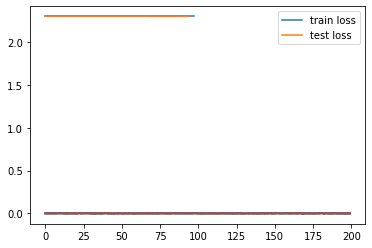

In [78]:
plt.plot(nn.loss[2:],label="train loss")
plt.plot(test_loss[5:],label="test loss")
# plt.plot(nn.second_last_activation[1])
plt.legend()

(1000, 64)
(1000, 784) (1000,)
(1000, 2) X shape


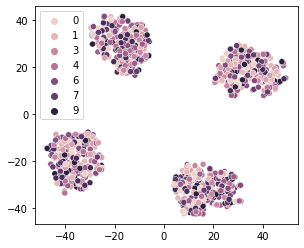

In [100]:
from sklearn.manifold import TSNE
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
import pandas as pd

nn_load = pd.read_pickle(r"/content/gdrive/MyDrive/Dataset/linear1.sav")
test_data = pd.read_csv('/content/gdrive/MyDrive/Dataset/mnist_test.csv',sep=",",header=None)
y_test = test_data.iloc[:,0].values
# print(y_test.shape)
X_test = (test_data.iloc[:,1:].values)
X_test,ax,y_test,ay=train_test_split(X_test,y_test,test_size=0.9,stratify=y_test)
nn_load.forward(X_test)
tSNE = TSNE(n_components=2)
print(nn.layer_values[-2].shape)
X = nn.layer_values[-2]
X = tSNE.fit_transform(X)
print(X_test.shape,y_test.shape)
print(X.shape,"X shape")
# X['Y'] = y
plt.figure(figsize=(16,4))
ax1 = plt.subplot(1, 3, 1)       #plotting the scatterplots to show the segregation of the datapoints
sns.scatterplot(
    x=X.T[0], y=X.T[1],
    hue=y_test,
    # palette=sns.color_palette("hls", 10),
    # data=X_test,
    # legend="full",
    # alpha=0.3,
    # ax=ax1
)
plt.show()